# Statistical analysis of group-level RSA results
<img src="images/expert.png" width="220" style="float: right">

In this notebook, we'll dive into cluster-based permutation testing, as described in [Maris & Oostenveld, 2007](https://doi.org/10.1016/j.jneumeth.2007.03.024).
This functionality is not part of the MNE-RSA package, but rather MNE-Python, but it is a large part of a proper RSA analysis so I figures any decent RSA tutorial should cover this.

Cluster-based permutation testing is becoming the standard "go-to" method for testing for significant differences between experimental conditions in MEG and EEG studies.
However, applying the technique correctly is not always straightforward and there are a lot of caveats to beware of.
On top of this, the API of MNE-Python regarding these tests could use a bit more work.
(If you are inspired by this tutorial, could you [lend a hand](https://github.com/mne-tools/mne-python/issues/4859) with this? ❤)


## The purpose of cluster-based permutation testing

When exploring differences between conditions, a good first step is to perform separate t-tests for each channel/sourcepoint/timepoint and visualize them.
While this gives you a good feel of where and when significant differences may occur, one cannot always make solid statistical inferences based on these values.
Cluster-based permutation testing is designed to solve two problems that arise when using mass t-tests:

 1. The multiple-comparisons problem: solved by using a cluster-based statistic
 2. The non-Gaussian data problem: solved by using random permutations

The solutions to these problems come at a hefty price though: the test can only infer the data is different between conditions. **The test can not be used to infer when and where there is a significant difference.**
Researchers get this wrong a lot.
The Fieldtrip manual even has a [dedicated page about this](https://www.fieldtriptoolbox.org/faq/how_not_to_interpret_results_from_a_cluster-based_permutation_test) which I encourage you to read.

Now that I've scared you enough, let's do this!

In the cell below, update the `data_path` variable to point to where you have extracted the [`rsa-data.zip`](https://github.com/wmvanvliet/neuroscience_tutorials/releases/download/2/rsa-data.zip) file to.

In [3]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 90  # Tune this to make figures bigger/smaller

import mne
mne.set_log_level("warning")  # Make the output less verbose

# Set this to where you've extracted `rsa-data.zip` to
data_path = "data"

## Cluster permutation testing on a single channel

In the classic EEG event-related potential (ERP) literature, statistical testing between two conditions was done by first identifying one or more sensors and stretches of time that seem likely to hold a significant difference, then averaging the signal across those sensors and time region, followed by a single t-test or ANOVA test.
Time would tell whether the chosen channels and time region would replicate across studies.

Let's do this for our sensor-level RSA result that we obtained in the first notebook.
I've ran the same analysis across multiple subjects and placed it in the `group_analysis` subfolder of the data package you've downloaded.
Executing the call below will load them.

In [4]:
import mne
subjects = [2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19]

# RSA against the RDM based on the pixels in each image
rsa_pixels = [mne.read_evokeds(f"{data_path}/group_analysis/sub-{subject:02d}-rsa-ave.fif", condition="pixels")
              for subject in subjects]

# RSA against the RDM based on the FaceNet embeddings of each image
rsa_facenet = [mne.read_evokeds(f"{data_path}/group_analysis/sub-{subject:02d}-rsa-ave.fif", condition="facenet")
               for subject in subjects]

`rsa_pixels` and `rsa_facenet` are now lists of [`mne.Evoked`](https://mne.tools/stable/generated/mne.Evoked.html) objects.
Here are the first 5 of them:

In [5]:
rsa_pixels[:5]

[<Evoked | 'pixels' (average, N=450), 0 – 0.9 s, baseline off, 1 ch, ~8 KiB>,
 <Evoked | 'pixels' (average, N=450), 0 – 0.9 s, baseline off, 1 ch, ~8 KiB>,
 <Evoked | 'pixels' (average, N=450), 0 – 0.9 s, baseline off, 1 ch, ~8 KiB>,
 <Evoked | 'pixels' (average, N=448), 0 – 0.9 s, baseline off, 1 ch, ~8 KiB>,
 <Evoked | 'pixels' (average, N=450), 0 – 0.9 s, baseline off, 1 ch, ~8 KiB>]

Every `Evoked` object has data defined for a single channel, for the time region 0 – 0.9 seconds.
The cell below compares the grand averages for pixels versus FaceNet and gives the 95% confidence intervals for the means:

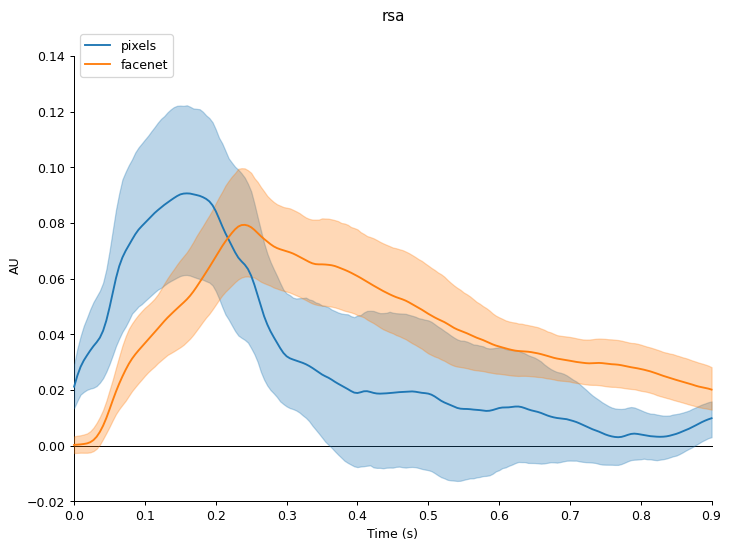

[<Figure size 720x540 with 1 Axes>]

In [6]:
mne.viz.plot_compare_evokeds(dict(pixels=rsa_pixels, facenet=rsa_facenet), picks=0, show_sensors=0, ylim=dict(misc=[-0.02, 0.15]))

Based on the above plot, there might be a significant difference very early on: 0 – 0.16 seconds.
Let's run a t-test in this time-window.

In [19]:
import numpy as np
from scipy.stats import ttest_rel

# Construct arrays with the data of all participants combined
data_pixels = np.array([ev.data[0] for ev in rsa_pixels])    # shape: 16 x 199 (participants x timepoints)
data_facenet = np.array([ev.data[0] for ev in rsa_facenet])  # shape: 16 x 199 (participants x timepoints)

# Time region we are interested in
tmin, tmax = 0, 0.16  # seconds

# Convert tmin/tmax to sample indices
tmin, tmax = np.searchsorted(rsa_pixels[0].times, [tmin, tmax])

# Average the data across the time window
data_pixels_avg = data_pixels[:, tmin:tmax].mean(axis=1)
data_facenet_avg = data_facenet[:, tmin:tmax].mean(axis=1)

# Perform the t-test
tval, pval = ttest_rel(data_pixels_avg, data_facenet_avg)

In [20]:
assert np.isscalar(tval), "We want a single t-value"
assert np.isscalar(pval), "We want a single p-value"
assert pval < 0.05, f"p-value is not significant {pval=}"

print(f"{tval=}, {pval=}   Looking great! 😊")

tval=np.float64(2.9768295878272895), pval=np.float64(0.009406024901266791)   Looking great! 😊


## The "cluster" part of cluster permutation tests

In essence, the permutation cluster test automates what we've just done above, but with a twist that we will get to later.

First, it must determine "clusters", i.e. regions of interest where there might be a significant difference between the conditions.
We eyeballed this based on the confidence interval of the mean, but the algorithm must use some form of automated function.
We can specify the function that the algorithm should use, but it comes with a useful default: a t-test: [`mne.stats.ttest_1samp_no_p`](https://mne.tools/stable/generated/mne.stats.ttest_1samp_no_p.html).

<div class="alert alert-block alert-warning">
    <b>COMMON CONFUSION</b><br>
    The initial t-test (or whatever stat function you chose) is just to form clusters, it is not used to determine significance!
</div>

Let's do this step manually first, so you get an understanding what is going on:
 - First, we do the t-test for every timepoint
   - This is a t-test against 0. To perform a paired t-test, we test `data_pixels - data_facenet`
 - Then, we set a threshold
 - Everything above the threshold becomes a cluster
 - We compute the sum of all the t-values inside the cluster

Sum of t-values in the cluster: 105.259


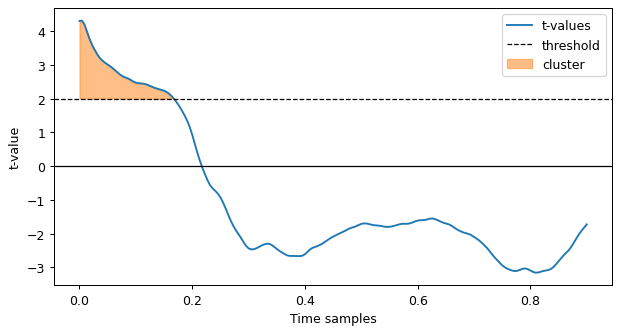

In [22]:
import matplotlib.pyplot as plt
from mne.stats import ttest_1samp_no_p
tvals = ttest_1samp_no_p(data_pixels - data_facenet)

# Plot the t-values and form a cluster
def plot_cluster(tvals, threshold, data_cond1, data_cond2):
    times = rsa_pixels[0].times

    # Make the cluster
    cluster = np.where(tvals > threshold)[0]

    # This is an important statistec: the sum of all t-values in the cluster
    cluster_tvals_sum = tvals[cluster].sum()

    # Show the t-values and how the cluster is determined
    plt.figure(figsize=(8, 4))
    plt.plot(times, tvals, label="t-values")
    plt.axhline(0, color="black", linewidth=1)
    plt.axhline(2, color="black", linestyle="--", linewidth=1, label="threshold")
    plt.fill_between(times[cluster], tvals[cluster], threshold * np.ones(len(cluster)), color="C1", alpha=0.5, label="cluster")
    plt.legend()
    plt.xlabel("Time samples")
    plt.ylabel("t-value")
    return cluster_tvals_sum

cluster_tvals_sum = plot_cluster(tvals, threshold=2, data_cond1=data_pixels, data_cond2=data_facenet)
print(f"Sum of t-values in the cluster: {cluster_tvals_sum:.3f}")

Based on the figure above, a threshold value of `2` seems to obtain a reasonable cluster.
We could have chosen a different threshold, and there is no reason to choose a threshold that corresponds to some p-value, other than perhaps providing a sensible default value.
The statistical function and the threshold used to form clusters are completely up to the researcher.
The idea here is to use your domain knowledge to increase statistical power: when clusters "make sense" regarding to what we know about the experimental setup and how MEG data behaves, we are likely to obtain better p-values in the end.

### The "permutation" part of the cluster permutation test
Now that we have our cluster, we can "permute" it to find what random clusters looks like.
In order to generate random clusters, we mix up the class labels.
Read the code in the cell below carefully to find out how this is done:

Sum of t-values in cluster: 0.0


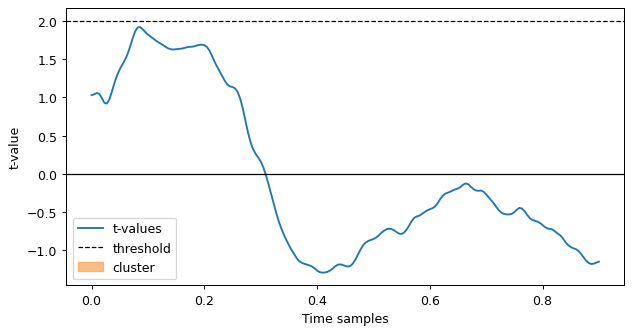

In [27]:
# Throw the data onto one big pile
big_pile = np.vstack((data_pixels, data_facenet))

# Shuffle the rows. This is what a "random permutation" means.
np.random.shuffle(big_pile)

# Divide again into the "pixels" and "facenet" conditions
permuted_pixels, permuted_facenet = big_pile[:len(subjects)], big_pile[len(subjects):]

# Compute t-values, which should be nice and low
permuted_tvals = ttest_1samp_no_p(permuted_pixels - permuted_facenet)

# See what the clusters look like now
permuted_cluster_tvals_sum = plot_cluster(permuted_tvals, threshold=2, data_cond1=permuted_pixels, data_cond2=permuted_facenet)
print("Sum of t-values in cluster:", permuted_cluster_tvals_sum.round(3))

You can run the cell above multiple times to see what different permutations look like.
If it is very rare that we get a cluster with larger max t-value than the one we found in the original data, we can say that there is a significant difference in the original data.
Finally, the percentage of times you find a larger max t-value in the randomly permuted data is your p-value.

And that is the cluster permutation test!

So, with all of this in mind, we can now use the MNE-Python [`permutation_cluster_1samp_test`](https://mne.tools/stable/generated/mne.stats.permutation_cluster_1samp_test.html) to perform everything we have done above in a single line of code.
When studying the line of code, keep the following in mind:
- Read the documentation of [`permutation_cluster_1samp_test`](https://mne.tools/stable/generated/mne.stats.permutation_cluster_1samp_test.html) first!
- The first parameter, `X` is your data matrix (`n_participants x n_times`). Since we are using paired t-tests to define clusters, you need to set this to `data_pixels - data_facenet` like we did before
- The threshold to form clusters is `2` like we used before
- We set `tail=1` to only look for positive t-values to mimic what we did before. You can also experiment with `-1` and `0` to look for clusters with negative t-values or both positive and negative.

In [48]:
from mne.stats import permutation_cluster_1samp_test
t_obs, clusters, pvals, H0 = permutation_cluster_1samp_test(X=data_pixels - data_facenet, threshold=2, tail=1)

If you wrote the call above correctly, executing the cell below will explain what all the return values mean:

In [29]:
times = rsa_pixels[0].times
print(f"t_obs (an array of length {len(t_obs)}) contains the initial t-values that are used to create the clusters.")
print(f"clusters (a list of length {len(clusters)}) contains for each cluster, the indices in the data array that are part of the cluster.")
print(f"pvals (an array of length {len(pvals)}) contains for each cluster a p-value, more about this later.")
print(f"H0 (an array of lenth {len(H0)}) contains the largest `permuted_cluster_tvals_sum` found in each random permutation.")
print()
print(f"The cluster permutation test found {len(clusters)} clusters.")
for i, cluster in enumerate(clusters):
    print(f"Cluster {i}: {times[cluster[0].min()]:.3f}-{times[cluster[0].max()]:.3f} seconds.")

t_obs (an array of length 199) contains the initial t-values that are used to create the clusters.
clusters (a list of length 1) contains for each cluster, the indices in the data array that are part of the cluster.
pvals (an array of length 1) contains for each cluster a p-value, more about this later.
H0 (an array of lenth 1024) contains the largest `permuted_cluster_tvals_sum` found in each random permutation.

The cluster permutation test found 1 clusters.
Cluster 0: 0.000-0.164 seconds.


### Computing the p-value

Depending on the value of `tail` you used in your call to [`permutation_cluster_1samp_test`](https://mne.tools/stable/generated/mne.stats.permutation_cluster_1samp_test.html), you have either 1, 2, or 3 clusters.
The clusters that your test found each have an associated p-value.

- If the sum-of-t-values for the cluster was **positive**, then the p-value is the fraction of random permutations that produced a cluster which a sum-of-t-values that was equal or **greater**
- If the sum-of-t-values for the cluster was **negative**, then the p-value is the fraction of random permutations that produced a cluster which a sum-of-t-values that was equal or **smaller**

To understand this better, lets use the `t_obs`, `clusters` and `H0` return values that you produced above to compute this p-value ourselves to test our knowledge of what these return values mean.
We will:
 - Loop over all the clusters you found
 - Determine the `sum_of_t_values` inside the cluster
 - Compute the fraction of `H0` whose absolute value is equal or larger than the absolute `sum_of_t_values`

In [43]:
print(f"The cluster p-values should be:\t{pvals}")
our_pvals = [(H0 >= t_obs[cluster].sum()).mean() for cluster in clusters]
print(f"Our manually computed cluster p-values are:\t{our_pvals}")

The cluster p-values should be:	[0.03417969]
Our manually computed cluster p-values are:	[np.float64(0.0341796875)]


### Interpreting the p-value

Now comes the twist that I mentioned in the beginning.
The final part of the cluster permutation test is that you use the **smallest** cluster p-value as final outcome of the test.
You might be tempted to judge the significance of each cluster separately based on its associated p-value, but that would be statistically incorrect.

<div class="alert alert-block alert-warning">
    <b>COMMON CONFUSION</b><br>
    The data inside a cluster was compared against random permutations of the dataset as a whole, not just the data inside the cluster.
    Hence, the test does not say whether a cluster by itself is statistically significant or not.
    The cluster permutation test only tells you whether the distribution of the data <b>as a whole</b> is significantly different between conditions.
    This is the price you pay to avoid the multiple comparisons problem.
</div>

So what can you do? [Sassenhagen & Draschkow 2019](https://onlinelibrary.wiley.com/doi/10.1111/psyp.13335) offer some good advice.
Personally, I would go for something like:

> The cluster-based permutation test revealed a significant difference between the conditions (p=SMALLEST_P_VALUE). This result was mostly driven by clusters at X (CLUSTER_PVAL) and Y (CLUSTER_PVAL), which correspond roughly to DESCRIPTION_OF_ROIS".

## Clusters across space and time
<img src="images/tardis.jpg" width="110" style="float:right; margin-left: 20px">

The formation of clusters becomes a bit more tricky in the case of [`SourceEstimate`](https://mne.tools/stable/generated/mne.SourceEstimate.html) objects, where data is defines across vertices in space as well as samples in time.

In this case, the first order of business is to morph everything to a template brain, so that the vertices are aligned.
This is common practice in MEG group analysis, so I'm not going to cover that process in this tutorial.

Instead, I have run the spatio-temporal RSA analysis that we did in the previous notebook across multiple subjects and placed the results in the `group_analysis` folder of your data package.
Let's load them and see if we can run a spatio-temporal cluster-based permutation test (quite a mouthful).

In [44]:
from mne import read_source_estimate
stc_pixels = [read_source_estimate(f"{data_path}/group_analysis/sub-{subject:02d}-rsa-pixels-morphed") for subject in subjects]
stc_facenet = [read_source_estimate(f"{data_path}/group_analysis/sub-{subject:02d}-rsa-facenet-morphed") for subject in subjects]

Now, `stc_pixels` and `stc_facenet` are two lists containing the [`SourceEstimate`](https://mne.tools/stable/generated/mne.SourceEstimate.html)'s for all subjects.
Here are 5 of them:

In [45]:
stc_pixels[:5]

[<SourceEstimate | 20484 vertices, tmin : 4.545454502105713 (ms), tmax : 495.45454072952265 (ms), tstep : 4.545454502105713 (ms), data shape : (20484, 109), ~8.7 MiB>,
 <SourceEstimate | 20484 vertices, tmin : 4.545454502105713 (ms), tmax : 495.45454072952265 (ms), tstep : 4.545454502105713 (ms), data shape : (20484, 109), ~8.7 MiB>,
 <SourceEstimate | 20484 vertices, tmin : 4.545454502105713 (ms), tmax : 495.45454072952265 (ms), tstep : 4.545454502105713 (ms), data shape : (20484, 109), ~8.7 MiB>,
 <SourceEstimate | 20484 vertices, tmin : 4.545454502105713 (ms), tmax : 495.45454072952265 (ms), tstep : 4.545454502105713 (ms), data shape : (20484, 109), ~8.7 MiB>,
 <SourceEstimate | 20484 vertices, tmin : 4.545454502105713 (ms), tmax : 495.45454072952265 (ms), tstep : 4.545454502105713 (ms), data shape : (20484, 109), ~8.7 MiB>]

Let's proceed as before by first looking at the difference between the means of the two conditions.
A neat feature of the [`SourceEstimate`](https://mne.tools/stable/generated/mne.SourceEstimate.html) class is that it supports common math operations such as `+`, `-`, `*` and `/`.
For example, computing the difference between the `pixels` and `facenet` RSA results of the first subject can simply be computed as `stc_diff = stc_pixels[0] - stc_facenet[0]`.
In the cell below, we compute the difference between the two conditions in a pairwise manner for each subject, then compute the mean across the pairwise differences.
If you want a nice elegant way to write this, remember that the [`zip()`](https://docs.python.org/3/library/functions.html#zip) function exists.

In [46]:
stc_pairwise_diff = np.mean([stc1 - stc2 for stc1, stc2 in zip(stc_pixels, stc_facenet)])

# Visualize the result.
stc_pairwise_diff.plot('fsaverage', subjects_dir=f"{data_path}/freesurfer", hemi="both", initial_time=0.121, views="caudal")

The figure shows us clear differences between the pixel versus FaceNet RSA scores across the visual cortex.

Let's explore this difference with a t-value map.
In order to compute t-values, we need to pull the data out of the [`SourceEstimate`](https://mne.tools/stable/generated/mne.SourceEstimate.html) objects.
As before, since we have a within-subject contrast between the two conditions, we want to perform pairwise tests.
So, as a first step, create a data array `X` of shape `(n_participants x n_vertices x n_times)` where each slice `i` along the first dimension is the difference between `stc_pixels[i].data - stc_facenet[i].data`.
The next step is running `X` through the [`mne.stats.ttest_1samp_no_p`](https://mne.tools/stable/generated/mne.stats.ttest_1samp_no_p.html) function to obtain t-values.

In [51]:
from mne.stats import ttest_1samp_no_p
X = np.array([stc1.data - stc2.data for stc1, stc2 in zip(stc_pixels, stc_facenet)])
tvals = ttest_1samp_no_p(X)

# Some sanity checks for our result
assert X.shape == (16, 20484, 109), "Your `X` array has the wrong shape. 🤔"
assert -0.17 < X.min() < -0.16, "Your `X` array does not have the correct values. 🤔"
assert 0.29 < X.max() < 0.30, "Your `X` array does not have the correct values. 🤔"

assert tvals.shape == (20484, 109), "Your `tvals` array has the wrong shape. 🤔"
assert -6.6 < tvals.min() < -6.5, "Your `tvals` array does not have the correct values. 🤔"
assert 7.4 < tvals.max() < 7.5, "Your `tvals` array does not have the correct values. 🤔"

print("All good! 😊")

All good! 😊


Now we can pack the `tvals` into a new [`SourceEstimate`](https://mne.tools/stable/generated/mne.SourceEstimate.html) object in order to visualize them:

In [52]:
stc_tvals = mne.SourceEstimate(
    data=tvals,
    vertices=stc_pixels[0].vertices,
    tmin=stc_pixels[0].tmin,
    tstep=stc_pixels[0].tstep,
    subject='fsaverage'
)
stc_tvals.plot('fsaverage', subjects_dir=f"{data_path}/freesurfer", hemi="both", initial_time=0.121, views="caudal")

False


From this figure, it seems that setting a threshold of `4` may result in useful clusters for our cluster-based permutation test.
The function to perform the test in both space and time is called [`mne.stats.spatio_temporal_cluster_1samp_test`](https://mne.tools/stable/generated/mne.stats.spatio_temporal_cluster_1samp_test.html).


But wait! Before you go and run the test, there's two things we need to take care of.

<div class="alert alert-block alert-warning">
<b>COMMON CONFUSION</b><br>
    
The order of the dimensions of `X`, namely `(n_subjects x n_vertices x n_samples)` is not how [`spatio_temporal_cluster_1samp_test`](https://mne.tools/stable/generated/mne.stats.spatio_temporal_cluster_1samp_test.html) wants them.
The function wants them as `(n_subjects x n_samples x n_vertices)`.
This is super unintuitive and everybody I know has gotten this wrong at least once.
So, first we need to do `X.transpose(0, 2, 1)` to get the dimensions in the proper order.
Please consider [helping us to improve the API](https://github.com/mne-tools/mne-python/issues/4859) and get this fixed.
</div>

The other this is that in order to form clusters across the cortex, we need to make sure that only neighbouring vertices are part of the same cluster.
This is a similar problem as we faced when computing searchlight patches in space during our RSA analysis.
The solution is found within the [`mne.SourceSpaces`](https://mne.tools/stable/generated/mne.SourceSpaces.html) object that keeps track of the distances between source points.
Since all of our data has been morphed to the `fsaverage` template brain, we need to load the [`SourceSpaces`](https://mne.tools/stable/generated/mne.SourceSpaces.html) object for that brain.
Then, we can compute the spatial adjacency matrix from the [`SourceSpaces`](https://mne.tools/stable/generated/mne.SourceSpaces.html) object through the [`mne.spatial_src_adjacency`](https://mne.tools/stable/generated/mne.spatial_src_adjacency.html) function.

In [55]:
src = mne.read_source_spaces(f"{data_path}/freesurfer/fsaverage/bem/fsaverage-ico-5-src.fif")
adj = mne.spatial_src_adjacency(src)

assert adj.shape == (20484, 20484), "You've `adj` seems to have the wrong shape. 🤔"
print("All good! 😊")

All good! 😊


Now it's time to run the big spatio-temporal cluster-based permutation test!
[Read its documentation first](https://mne.tools/stable/generated/mne.stats.spatio_temporal_cluster_1samp_test.html) and then go for it!

In [58]:
from mne.stats import spatio_temporal_cluster_1samp_test
t_obs, clusters, pvals, H0 = spatio_temporal_cluster_1samp_test(X.transpose(0, 2, 1), threshold=4, tail=1,
                                                                adjacency=adj, n_jobs=-1, verbose=True)

# What is the smallest cluster p-value that we found? Was it significant? (p < 0.05?)
print("Smallest p-value:", pvals.min())
if pvals.min() < 0.05:
    print("It was significant! 🎉")
else:
    print("It was not significant 🤔")

stat_fun(H1): min=-6.571207046508789 max=7.4570088386535645
Running initial clustering …
Found 99 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

Smallest p-value: 0.0009765625
It was significant! 🎉


MNE-Python comes with a function called [`mne.stats.summarize_clusters_stc`]() that shows the spatial extent of the clusters:

In [59]:
from mne.stats import summarize_clusters_stc
stc_all_cluster_vis = summarize_clusters_stc(
    (t_obs, clusters, pvals, H0),  # output of spatio_temporal_cluster_1samp_test
    tstep=stc_pixels[0].tstep, # difference in time between two time samples
    vertices=stc_pixels[0].vertices, # vertex numbers
    subject="fsaverage",  # FreeSurfer subject whose brain to draw
    p_thresh=0.05,  # Only show clusters with an associated p-value below this threshold
)

# Plot the summary created by summarize_clusters_stc
stc_all_cluster_vis.plot(
    hemi="both",
    views="ventral",
    subjects_dir=f"{data_path}/freesurfer",
    time_label="temporal extent (ms)",
    clim=dict(kind="value", pos_lims=[0, 0.01, 0.11]),
)

False


In the figure above, the first time point shows all the clusters and the subsequent timepoints show each cluster individually.
The colors indicate the extent of the cluster in time (=number of samples).

<center>
    <span style="font-size: 30pt">🎉 CONGRATULATIONS 🎉</span><br>
    You've reached the end of this tutorial series and mastered the spatio-temporal cluster-based permutation test!
</center>